In [2]:
from gurobipy import *

lp = Model(name = "LP")
x = lp.addVar(name = "x", lb = 0)
y = lp.addVar(name = "y", lb = 0)
lp.setObjective(5*x+4*y, GRB.MINIMIZE)
c1 = lp.addConstr(x+y>=8, name="c1")
c2 = lp.addConstr(2*x+y>=10, name="c2")
c3 = lp.addConstr(x+4*y>=11, name="c3")
lp.optimize()
lp.write("linear_model.lp")

Academic license - for non-commercial use only - expires 2024-06-25
Using license file C:\Users\Jacob\gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 3 rows, 2 columns and 6 nonzeros
Model fingerprint: 0x6c7cdc94
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [4e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+01]
Presolve time: 0.01s
Presolved: 3 rows, 2 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.850000e+01   0.000000e+00      0s
       2    3.4000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds
Optimal objective  3.400000000e+01


In [3]:
lp.getVars()

[<gurobi.Var x (value 2.0)>, <gurobi.Var y (value 6.0)>]

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 4 rows, 4 columns and 5 nonzeros
Model fingerprint: 0xc9fb948a
Model has 2 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-01, 2e-01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+01]
Presolve removed 3 rows and 1 columns
Presolve time: 0.01s
Presolved: 9 rows, 7 columns, 15 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.700e+01
 Factor NZ  : 4.500e+01
 Factor Ops : 2.850e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.93468375e-01  6.93468375e-01  1.85e+00 1.01e+00  1.45e+00     0s
 

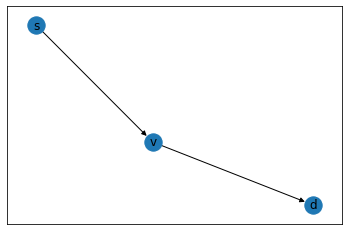

In [4]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from([("s", {"s": 5}), ("d", {"d": 0.5})])
G.add_edges_from([("s", "v", {"c":1, "r":0.1, "u":1}), ("v", "d", {"c":0, "r":0.2, "u":10})])
nx.draw_networkx(G)

qcqp = Model(name = "QCQP")
x, y = {}, {}
for a in G.edges:
    x[a] = qcqp.addVar(name = f"x_{a}", lb = 0, obj = G.edges[a]["c"])
    y[a] = qcqp.addVar(name = f"y_{a}", lb = 0)
    qcqp.addConstr(G.edges[a]["r"] * x[a]**2 - x[a] + y[a] <= 0)
    qcqp.addConstr(x[a] <= G.edges[a]["u"])
for v in G.nodes:
    in_flows = [y[a] for a in G.in_edges(v)]
    out_flows = [x[a] for a in G.out_edges(v)]
    if v == "d":
        qcqp.addConstr(quicksum(in_flows) == G.nodes[v]["d"])
    elif v != "s":
        qcqp.addConstr(quicksum(in_flows) == quicksum(out_flows))
qcqp.modelSense = GRB.MINIMIZE
print(qcqp.optimize())
qcqp.write("qcqp.lp")
print(qcqp.getVars())

In [54]:
from matplotlib import pyplot as plt
from gurobipy import Model, quicksum, GRB
import grid2op
import networkx as nx

def plot_multigraph(G):
    pos = nx.spring_layout(G) # Alternatively: planar_layout
    names = {name: name for name in G.nodes}
    nx.draw_networkx_nodes(G, pos, node_color = 'b', node_size = 500, alpha = 1)
    nx.draw_networkx_labels(G,pos,names,font_size=10,font_color='w')
    ax = plt.gca()
    for e in G.edges:
        ax.annotate("",
                    xy=pos[e[1]], xycoords='data',
                    xytext=pos[e[0]], textcoords='data',
                    arrowprops=dict(arrowstyle="->", color="0",
                                    shrinkA=10, shrinkB=10,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])
                                    ),
                                    ),
                    )
    plt.axis('off')
    plt.show()


def find_optimal_flow(G, verbose=False):
    qcqp = Model(name = "QCQP")
    x, y = {}, {}
    for a in G.edges:
        x[a] = qcqp.addVar(name = f"x_{a}", lb = 0, obj = G.edges[a]["c"])
        y[a] = qcqp.addVar(name = f"y_{a}", lb = 0)
        qcqp.addConstr(G.edges[a]["r"] * x[a]**2 - x[a] + y[a] <= 0)
        qcqp.addConstr(x[a] <= G.edges[a]["u"])
    for v in G.nodes:
        in_flows = [y[a] for a in G.in_edges(v, keys=True)]
        out_flows = [x[a] for a in G.out_edges(v, keys=True)]
        if v == "d":
            qcqp.addConstr(quicksum(in_flows) == G.nodes[v]["d"])
        elif v != "s":
            qcqp.addConstr(quicksum(in_flows) == quicksum(out_flows))
    qcqp.modelSense = GRB.MINIMIZE
    qcqp.Params.LogToConsole = int(verbose)
    #qcqp.Params.BarQCPConvTol = 1e-12
    #qcqp.Params.FeasibilityTol = 1e-9
    qcqp.optimize()
    qcqp.write("qcqp.lp")
    variables = {var.VarName : var.X for var in qcqp.getVars()}
    return qcqp.objVal, variables


def print_flow(cost, flow, merged=False):
    print("---------------------------------------------")
    # Merging antiparallel flows will typically reduce the cost. As `cost` is the cost of the unmerged flow it
    # thus tends to be a slight overapproximation of the cost of the merged flow
    print(f"Obtained solution of value {'at most' if merged else ''} {cost}:")
    for name, value in flow.items():
        print(f"\t{name}: {value}")
    print("---------------------------------------------")
    

def algorithm2(G, T):
    sources, sinks, arcs = G.graph["sources"], G.graph["sinks"], G.edges
    Gp = nx.MultiDiGraph()
    Gp.add_node("d", d=sum(attr["d"] for _, attr in sinks))
    for u, v, attr in arcs(data=True):
        Gp.add_edge(u, v, c=0, r=attr["r"], u=attr["u"])
    for src, attr in sources:
        for length, cost in attr["c"]:
            Gp.add_edge("s", src, c=T*cost, r=0, u=length/T)
    for sink, attrs in sinks:
        Gp.add_edge(sink, "d", c=0, r=0, u=attrs["d"])
    return Gp


def algorithm3(G):
    # Steps 1 & 4
    src_connected = set(nx.multi_source_dijkstra_path_length(
        G, [v for v,_ in G.graph["sources"]]).keys())
    sink_connected = set(nx.multi_source_dijkstra_path_length(
        G, [v for v,_ in G.graph["sinks"]]).keys())
    relevant = src_connected.intersection(sink_connected)
    Gp = G.subgraph(relevant).to_directed()
    Gp.graph["sources"] = []
    Gp.graph["sinks"] = []
    # Step 2
    for src, attr in G.graph["sources"]:
        if "cr" in attr:
            # Step 2a
            for i, (length, cost) in enumerate(attr["cr"]):
                node = f"{src}_{i}"
                Gp.graph["sources"].append((node, {"c": [(length,cost)]}))
                Gp.add_node(node, c=cost)
                Gp.add_edge(node, src, r=0, u=length)
            del Gp.nodes[src]["cr"]
        else:
            # Step 2b
            node = f"{src}'"
            Gp.graph["sources"].append((node, attr))
            Gp.add_node(node, c=attr["c"])
            csupply = sum(l for l,_ in attr["c"])
            Gp.add_edge(node, src, r=0, u=csupply)
            del Gp.nodes[src]["c"]
    # Step 3
    for sink, attr in G.graph["sinks"]:
        node = f"{sink}'"
        Gp.graph["sinks"].append((node, attr))
        Gp.add_node(node, d=attr["d"])
        Gp.add_edge(sink, node, r=0, u=attr["d"])
        del Gp.nodes[sink]["d"]
    return Gp


def to_original_graph_flow(flow, G):
    """First get rid of variables corresponding to arcs not present in the original graph.
    Then, for each pair of antiparallel arcs, subtract the smaller flow from the larger flow and remove
    the variables corresponding to the smaller flow (adds waste to that arc unless resistance is 0)."""
    flow = flow.copy()
    for arc in G.out_edges("s", keys=True):
        del flow[f"x_{arc}"]
        del flow[f"y_{arc}"]
        # Without this if-statement we'd try to remove out-arcs of arc[1] once per parallel (arc[0],arc[1]) arc
        if arc[2] == 0:
            for narc in G.out_edges(arc[1], keys=True):
                del flow[f"x_{narc}"]
                del flow[f"y_{narc}"]
    for arc in G.in_edges("d", keys=True):
        del flow[f"x_{arc}"]
        del flow[f"y_{arc}"]
        for parc in G.in_edges(arc[0], keys=True):
            del flow[f"x_{parc}"]
            del flow[f"y_{parc}"]
    for arc in G.edges:
        if f"x_{arc}" in flow:
            aarc = (arc[1], arc[0], arc[2])
            # Shortcut way to check if forward flow beats backwards flow, assuming the flows differ by orders of magnitude
            if flow[f"y_{arc}"] > flow[f"x_{aarc}"]:
                flow[f"y_{arc}"] -= flow[f"x_{aarc}"]
                flow[f"x_{arc}"] -= flow[f"y_{aarc}"]
                del flow[f"x_{aarc}"]
                del flow[f"y_{aarc}"]
    return flow


def solve(G, verbosity=1):
    Gp = algorithm3(G)
    Gpp = algorithm2(Gp, 1)
    if verbosity > 1:
        nx.draw_networkx(G)
        plt.show()
        plot_multigraph(Gp)
        plot_multigraph(Gpp)
    cost, flow = find_optimal_flow(Gpp, verbose=(verbosity>1))
    merged_flow = to_original_graph_flow(flow)
    if verbosity > 0:
        print_flow(cost, merged_flow, merged=True)
    return merged_flow


def fetch_l2rpn_graph(name):
    env = grid2op.make(name)
    obs = env.reset()
    rawG = obs.get_energy_graph()

    G = nx.MultiGraph(sources=[], sinks=[])
    for node, attr in rawG.nodes(data=True):
        net_out = attr["p"] / 75 * 1e3
        if net_out > 0:
            node_w_data = (node, {"c": [(net_out/2, 1), (net_out/2, 2)]})
            G.graph["sources"].append(node_w_data)
            G.add_nodes_from([node_w_data])
        if net_out < 0:
            node_w_data = (node, {"d": -net_out})
            G.graph["sinks"].append(node_w_data)
            G.add_nodes_from([node_w_data])
    for u, v, attr in rawG.edges(data=True):
        arc_w_data = (u, v, {"r": 1e-3, "u": attr["thermal_limit"]})
        G.add_edges_from([arc_w_data])
    return G

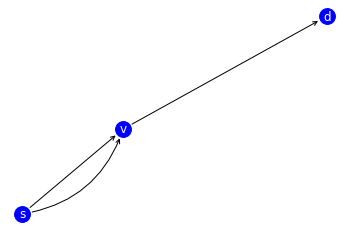

---------------------------------------------
Obtained solution of value 1.779107456448168:
	x_('s', 'v', 0): 0.9999999984049698
	y_('s', 'v', 0): 0.9999999980385236
	x_('s', 'v', 1): 0.389553729021599
	y_('s', 'v', 1): 0.3819660134294132
	x_('v', 'd', 0): 1.3819660114298642
	y_('v', 'd', 0): 1.0
---------------------------------------------


In [6]:
G = nx.MultiDiGraph()
G.add_node("d", d=1)
G.add_edges_from([
    ("s", "v", {"c":1, "r":0, "u":1}),
    ("s", "v", {"c":2, "r":0.05, "u":1}),
    ("v", "d", {"c":0, "r":0.2, "u":10})])
plot_multigraph(G)
cost, flow = find_optimal_flow(G)
print_flow(cost, flow)

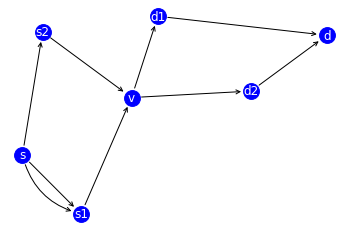

---------------------------------------------
Obtained solution of value 0.5458614253611644:
	x_('s1', 'v', 0): 0.34862551862481284
	y_('s1', 'v', 0): 0.22708576619814053
	x_('v', 'd1', 0): 0.10208424046510986
	y_('v', 'd1', 0): 0.099999999975609
	x_('v', 'd2', 0): 0.20416847669236307
	y_('v', 'd2', 0): 0.19999999997653495
	x_('s2', 'v', 0): 0.09861795219878976
	y_('s2', 'v', 0): 0.0791669509575198
	x_('d1', 'd', 0): 0.09999999997560614
	y_('d1', 'd', 0): 0.0999999999648355
	x_('d2', 'd', 0): 0.19999999997653925
	y_('d2', 'd', 0): 0.19999999997575732
	x_('s', 's1', 0): 0.3486255191315939
	y_('s', 's1', 0): 0.3486255185546076
	x_('s', 's1', 1): 1.3743564692750105e-10
	y_('s', 's1', 1): 7.433045350363084e-11
	x_('s', 's2', 0): 0.09861795242760701
	y_('s', 's2', 0): 0.09861795220318323
---------------------------------------------


In [17]:
T = 1
# c is the \prodcpus_s, and is structured as (csupply, cost)
G = nx.DiGraph(sources = [
    ("s1", {"c":[(1,1),(1,10)]}),
    ("s2", {"c":[(2,2)]}),
], sinks = [
    ("d1", {"d":0.1}),
    ("d2", {"d":0.2}),
])


G.add_nodes_from(G.graph["sources"])
G.add_nodes_from(G.graph["sinks"])
G.add_edges_from([
    ("s1", "v", {"r":1, "u":1}),
    ("s2", "v", {"r":2, "u":1}),
    ("v", "d1", {"r":0.2, "u":10}),
    ("v", "d2", {"r":0.1, "u":10})])

Gp = algorithm2(G, T)
plot_multigraph(Gp)
cost, flow = find_optimal_flow(Gp)
print_flow(cost, flow)

{'sources': [("s1'", {'c': [(1, 1), (1, 10)]}), ("s2'", {'c': [(2, 2)]}), ('s3_0', {'c': [(2, 1)]}), ('s3_1', {'c': [(1, 5)]})], 'sinks': [("d1'", {'d': 0.1}), ("d2'", {'d': 0.2})]}


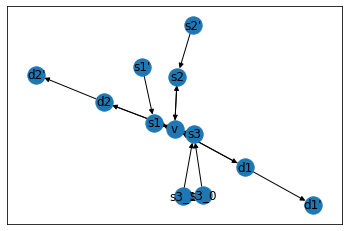

In [21]:
# c is the \prodcpus_s, and is structured as (csupply, cost)
G = nx.Graph(sources = [
    ("s1", {"c":[(1,1),(1,10)]}),
    ("s2", {"c":[(2,2)]}),
    ("s3", {"cr":[(2,1),(1,5)]}),
], sinks = [
    ("d1", {"d":0.1}),
    ("d2", {"d":0.2}),
])
G.add_nodes_from(G.graph["sources"])
G.add_nodes_from(G.graph["sinks"])
G.add_edge("tst1", "tst2")
G.add_edges_from([
    ("s1", "v", {"r":1, "u":1}),
    ("s2", "v", {"r":2, "u":1}),
    ("s3", "v", {"r":3, "u":1}),
    ("v", "d1", {"r":0.2, "u":10}),
    ("v", "d2", {"r":0.1, "u":10})])

nx.draw_networkx(algorithm3(G))
print(algorithm3(G).graph)

# TODO: Make sources and sinks internal to graph somehow and set in algs,
# such that we can solve Problem1 automatically using
# find_optimal_flow(algorithm2(algorithm3(G), T))

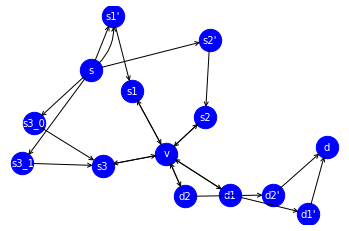

In [43]:
plot_multigraph(algorithm2(algorithm3(G), 1))

In [128]:
Gpp = algorithm2(algorithm3(G), 1)
cost, flow = find_optimal_flow(Gpp)
print_flow(cost, flow)

---------------------------------------------
Obtained solution of value  0.4546732681953448:
	x_('s1', 'v', 0): 0.2863160594356005
	y_('s1', 'v', 0): 0.2043391649764776
	x_('v', 's1', 0): 2.1902443610144492e-08
	y_('v', 's1', 0): 2.0194091064534793e-08
	x_('v', 's2', 0): 6.529739008305849e-07
	y_('v', 's2', 0): 6.372364532303553e-07
	x_('v', 's3', 0): 1.862758180590815e-08
	y_('v', 's3', 0): 1.6942186809909856e-08
	x_('v', 'd1', 0): 0.10208445643343816
	y_('v', 'd1', 0): 0.10000020711633975
	x_('v', 'd2', 0): 0.20416864923480746
	y_('v', 'd2', 0): 0.20000016523738112
	x_('s2', 'v', 0): 0.03644487259536574
	y_('s2', 'v', 0): 0.03378838794821097
	x_('s3', 'v', 0): 0.09546870636659145
	y_('s3', 'v', 0): 0.06812587725034983
	x_('d1', 'v', 0): 2.070552361120466e-07
	y_('d1', 'v', 0): 2.052856119823515e-07
	x_('d1', "d1'", 0): 0.10000000001532566
	y_('d1', "d1'", 0): 0.1000000000074297
	x_("d1'", 'd', 0): 0.10000000001022356
	y_("d1'", 'd', 0): 0.10000000004461525
	x_('d2', 'v', 0): 1.65181

In [95]:
print_flow(cost, to_original_graph_flow(flow, Gpp))

---------------------------------------------
Obtained solution of value 0.4546732681953448:
	x_('s1', 'v', 0): 0.2863160594356005
	y_('s1', 'v', 0): 0.2043391649764776
	x_('v', 's1', 0): 2.1902443610144492e-08
	y_('v', 's1', 0): 2.0194091064534793e-08
	x_('v', 's2', 0): 6.529739008305849e-07
	y_('v', 's2', 0): 6.372364532303553e-07
	x_('v', 's3', 0): 1.862758180590815e-08
	y_('v', 's3', 0): 1.6942186809909856e-08
	x_('v', 'd1', 0): 0.10208445643343816
	y_('v', 'd1', 0): 0.10000020711633975
	x_('v', 'd2', 0): 0.20416864923480746
	y_('v', 'd2', 0): 0.20000016523738112
	x_('s2', 'v', 0): 0.03644487259536574
	y_('s2', 'v', 0): 0.03378838794821097
	x_('s3', 'v', 0): 0.09546870636659145
	y_('s3', 'v', 0): 0.06812587725034983
	x_('d1', 'v', 0): 2.070552361120466e-07
	y_('d1', 'v', 0): 2.052856119823515e-07
	x_('d2', 'v', 0): 1.6518141467933964e-07
	y_('d2', 'v', 0): 1.6393211918459937e-07
---------------------------------------------


In [100]:
print_flow(cost, to_original_graph_flow(flow, Gpp), merged=True)

---------------------------------------------
Obtained solution of value at most 0.4546732681953448:
	x_('s1', 'v', 0): 0.28631603924150945
	y_('s1', 'v', 0): 0.204339143074034
	x_('v', 'd1', 0): 0.10208425114782618
	y_('v', 'd1', 0): 0.10000000006110364
	x_('v', 'd2', 0): 0.20416848530268827
	y_('v', 'd2', 0): 0.20000000005596644
	x_('s2', 'v', 0): 0.03644423535891251
	y_('s2', 'v', 0): 0.03378773497431014
	x_('s3', 'v', 0): 0.09546868942440465
	y_('s3', 'v', 0): 0.06812585862276802
---------------------------------------------


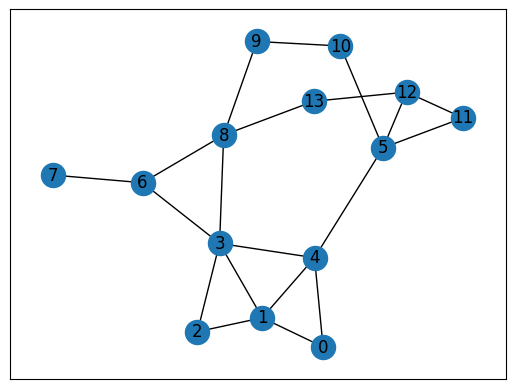

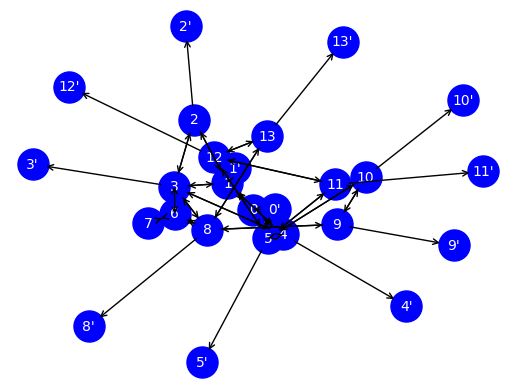

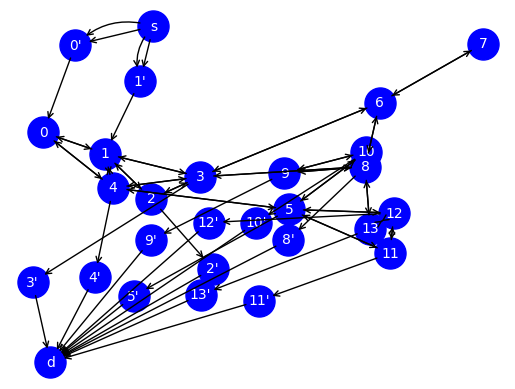

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 93 rows, 132 columns and 194 nonzeros
Model fingerprint: 0x3f1bba02
Model has 66 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-03, 1e-03]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 2e+03]
Presolve removed 66 rows and 0 columns
Presolve time: 0.01s
Presolved: 213 rows, 212 columns, 460 nonzeros
Presolved model has 40 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.880e+02
 Factor NZ  : 1.942e+03
 Factor Ops : 2.207e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal   

AttributeError: Unable to retrieve attribute 'X'

In [53]:
import grid2op
import networkx as nx
import matplotlib.pyplot as plt

env_name = "l2rpn_case14_sandbox"
G = fetch_l2rpn_graph(env_name)
flow = solve(G, verbosity=2)

In [55]:
len(G.nodes)





14